In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow.keras import layers

In [ ]:
amazon = pd.read_csv("AMZN.csv", parse_dates=["Date"])

In [ ]:
amazonData = pd.DataFrame()

In [ ]:
amazonData

,Day,Close
0,3,1.958333
1,4,1.729167
2,0,1.708333
3,1,1.635417
4,2,1.427083
...,...,...
5753,3,1955.489990
5754,4,1900.099976
5755,0,1963.949951
5756,1,1949.719971


## Preprocessing Data

In [ ]:
amazonData['Day'] = amazon['Date'].dt.dayofweek

In [ ]:
amazonData['Close'] = amazon['Close'].values.reshape(-1, 1)

In [ ]:
def createWindow(data, window_size, horizon):
    X = []
    Y = []
    for i in range(len(data)-window_size):
        if((data.loc[i,'Day'] == 0) & (data.loc[i+window_size-1, 'Day'] == 4)):
            X.append(data.loc[i:i+window_size-1, 'Close'].values)
            Y.append(data.loc[i+window_size, 'Close'])
    return X, Y

In [ ]:
window_size = 5
horizon = 1

In [ ]:
amazonX, amazonY = createWindow(amazonData, window_size, horizon)

In [ ]:
split_size_train = int(0.8 * len(amazonX)) # 80% train, 10% test, 10% val
split_size_test = int(0.1 * len(amazonX))
split_size_val = len(amazonData) - split_size_train - split_size_test

amazonXTrain = amazonX[:split_size_train]
amazonXTest = amazonX[split_size_train:split_size_train + split_size_test]
amazonXVal = amazonX[split_size_train + split_size_test:]
amazonYTrain = amazonY[:split_size_train]
amazonYTest = amazonY[split_size_train:split_size_train + split_size_test]
amazonYVal = amazonY[split_size_train + split_size_test:]

print(len(amazonXTrain))
print(len(amazonXTest))
print(len(amazonXVal))
print(len(amazonYTrain))
print(len(amazonYTest))
print(len(amazonYVal))

788
98
100
788
98
100


In [ ]:
train_inputs = np.array(amazonXTrain)
train_outputs = np.array(amazonYTrain)
test_inputs = np.array(amazonXTest)
test_outputs = np.array(amazonYTest)
val_inputs = np.array(amazonXVal)
val_outputs = np.array(amazonYVal)

## Baseline Architecture

In [ ]:
tf.random.set_seed(42)

inputs = layers.Input(shape=(window_size))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
x = layers.LSTM(50, activation="relu")(x)
output = layers.Dense(1)(x)
model_1 = tf.keras.Model(inputs=inputs, outputs=output)

model_1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_1.fit(train_inputs,
            train_outputs,
            epochs=100,
            verbose=0,
            batch_size=128,
            validation_data=(val_inputs, val_outputs))

## Architecture Modification

In [ ]:
tf.random.set_seed(42)

inputs = layers.Input(shape=(window_size))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
x = layers.LSTM(256, activation="relu")(x)
output = layers.Dense(1)(x)
model_1_mod = tf.keras.Model(inputs = inputs, outputs = output)

model_1_mod.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_1_mod.fit(train_inputs,
            train_outputs,
            epochs=100,
            verbose=0,
            batch_size=128,
            validation_data=(val_inputs, val_outputs))

Explanation:

A simple complexity enhancement was introduced to the baseline architecture that had been previously established. This enhancement involved increasing the number of units from 50 to 250. Consequently, the model possesses greater capacity to depic complex representations of the data. Moreover, this expanded capacity enables the model to capture non-linear patterns, a valuable feature when dealing with stock market data.

## Visualization

4/4 [==============================] - 0s 9ms/step


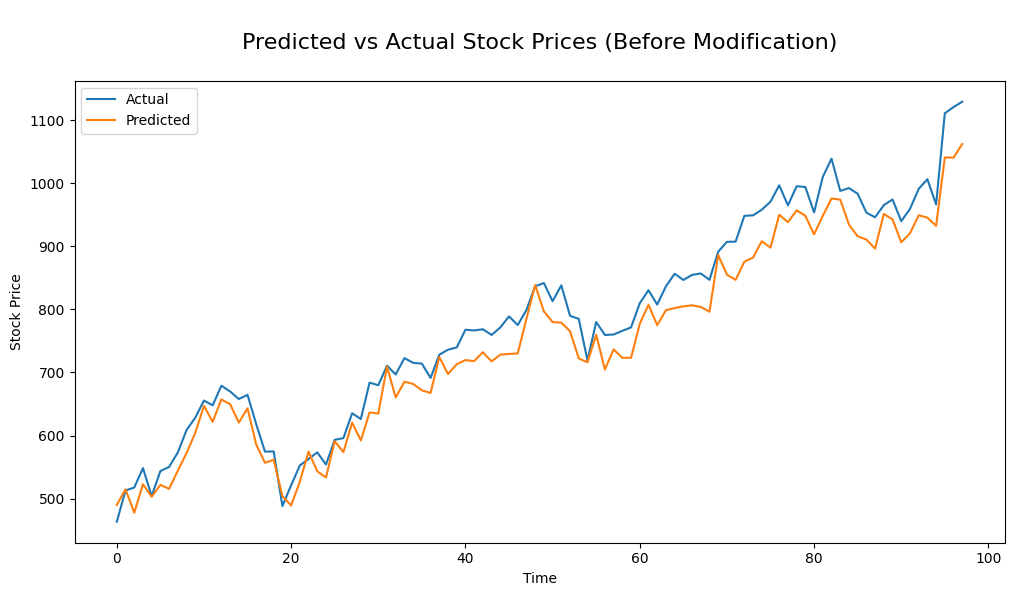

In [ ]:
predictions_baseline = model_1.predict(test_inputs)

plt.figure(figsize=(12, 6))
plt.plot(test_outputs, label='Actual')
plt.plot(predictions_baseline, label='Predicted')
plt.title('\nPredicted vs Actual Stock Prices (Before Modification)\n', fontsize=16)
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

4/4 [==============================] - 0s 4ms/step


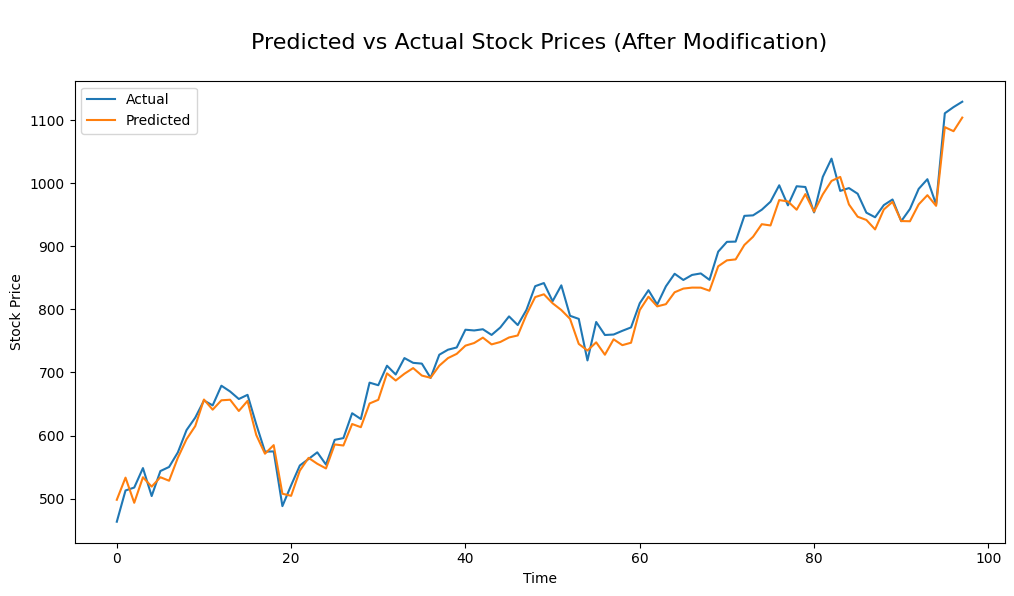

In [ ]:
predictions = model_1_mod.predict(test_inputs)

plt.figure(figsize=(12, 6))
plt.plot(test_outputs, label='Actual')
plt.plot(predictions, label='Predicted')
plt.title('\nPredicted vs Actual Stock Prices (After Modification)\n', fontsize=16)
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

Evaluation

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

prediction = model_1.predict(val_inputs)
rmse = np.sqrt(mean_squared_error(val_outputs, prediction))
mae = mean_absolute_error(val_outputs, prediction)
mape = mean_absolute_percentage_error(val_outputs, prediction)

prediction1 = model_1_mod.predict(val_inputs)
rmse1 = np.sqrt(mean_squared_error(val_outputs, prediction1))
mae1 = mean_absolute_error(val_outputs, prediction1)
mape1 = mean_absolute_percentage_error(val_outputs, prediction1)


print("Amazon Dataset")
print("=======================")
print("Baseline Architecture:")
print("RMSE: ", rmse)
print("MAE: ", mae)
print("MAPE: ", mape)
print("\nModified Architecture:")
print("RMSE: ", rmse1)
print("MAE: ", mae1)
print("MAPE: ", mape1)

4/4 [==============================] - 0s 4ms/step
Amazon Dataset
Baseline Architecture:
RMSE:  98.46546066508076
MAE:  88.55598999023438
MAPE:  0.05121940680299168

Modified Architecture:
RMSE:  53.50284891393329
MAE:  47.095755615234374
MAPE:  0.02730637070724653


Explanation:

Notably, when examining the modified values of RMSE, MAE and MAPE it becomes evident that the modified architecture outperforms the baseline architecture in terms of accuracy.

This observation underscores the significance of judiciously augmenting the complexity of a model's architecture as it evidently has a discernible impact on its performance.